#Deep Learning with Multi-Label Classification for Psychotic Disorder Diseases
Manupria Arora (manupri2@illinois.edu) and Vraj Patel (vpate33@illinois.edu)

In [ ]:
import os
import math
import numpy as np
import pandas as pd
from google.colab import files

In [ ]:
# Importing the library
import psutil
'''
!lscpu |grep 'Model name'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
print('RAM memory % used:', psutil.virtual_memory()[2])
'''

"\n!lscpu |grep 'Model name'\n!lscpu | grep 'Core(s) per socket:'\n!lscpu | grep 'Thread(s) per core'\n"

##Processing the Data
The steps taken here are similar to the steps taken in the paper "*Application of deep and machine learning techniques for multi-label classification performance on psychotic disorder diseases*".



1.   Load in the proper data (Provided as public supplementary data from the original paper).
2.   Create one-hot encoding vectors for each of the five target variables we are interested in.
3.   Apply the conventional multiclass SMOTE on the concatenated target variables.

###1. Load in the Data
The first steps includes loading in the provided data. But before laoding in the data, we had to manually remove some rows. The paper mentioned that it was recommended to remove rows with target combinations that appeared only a few times throughout the data set. Matching the paper, the columns that were identified with less than 6 neighbors included: `11100, 01111,
10011, 00110, 00010, 10100, 10111`. Subsequently, these were the rows that were removed from the data.

Once manual processing is completed, load in the supplementary data. Make sure the name of file is `PDD_supplementary.csv`.

In [ ]:
# If the file is not present, add the file
if not os.path.isfile("PDD_supplementary.csv"):
  uploaded = files.upload() # Load in the desired file

In [ ]:
# Load the data in
data = pd.read_csv('PDD_supplementary.csv')

# View some of the features of the file
print(data.head())
print("data.shape: ",data.shape)
print(data.columns)

   Unnamed: 0 sex  age faNoily_status religion occupation genetic status  \
0           0   M   18            Yes        C    STUDENT     Yes      S   
1           2   M   22            Yes        C    STUDENT      No      S   
2           3   M   35             No        M    ARTISAN      No      M   
3           4   M   30            Yes        M    ARTISAN     Yes      M   
4           5   F   86            Yes        C    RETIRED      No      M   

  loss_of_parent divorse Injury Spiritual_consult  Insominia  shizopherania  \
0            Yes      No     No               Yes          0              1   
1             No      No     No               Yes          1              1   
2             No      No     No               Yes          1              1   
3             No      No     No               Yes          1              1   
4            Yes      No     No               Yes          0              1   

   vascula_demetia  MBD  Bipolar  agecode  target  
0               

In [ ]:
# We can drop some of the columns that are not explained in the paper
data = data.drop(['Unnamed: 0','agecode'], axis="columns")
# We can now view the data to see what it looks like
data

,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,target
0,M,18,Yes,C,STUDENT,Yes,S,Yes,No,No,Yes,0,1,1,1,0,1110
1,M,22,Yes,C,STUDENT,No,S,No,No,No,Yes,1,1,1,0,1,11101
2,M,35,No,M,ARTISAN,No,M,No,No,No,Yes,1,1,0,0,1,11001
3,M,30,Yes,M,ARTISAN,Yes,M,No,No,No,Yes,1,1,1,1,1,11111
4,F,86,Yes,C,RETIRED,No,M,Yes,No,No,Yes,0,1,1,0,0,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,F,73,Yes,M,RETIRED,Yes,S,Yes,No,No,Yes,1,0,1,0,1,10101
480,F,50,No,M,ARTISAN,No,M,Yes,No,No,No,1,1,0,1,1,11011
481,F,32,No,C,FORCE,No,M,No,No,No,Yes,0,1,1,1,0,1110
482,M,13,Yes,C,STUDENT,No,S,Yes,No,No,No,0,1,0,0,0,1000


####Feature and Target Vectors
Split the data into feature vectors and target vectors to ease the process of one-hot encoding

In [ ]:
# The features that we are interested in (Training data)
target_cols = ['Insominia','shizopherania','vascula_demetia','MBD','Bipolar','target'];
features = data.drop(target_cols, axis='columns')
print("features.shape: ", features.shape)
features

features.shape:  (484, 11)


,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult
0,M,18,Yes,C,STUDENT,Yes,S,Yes,No,No,Yes
1,M,22,Yes,C,STUDENT,No,S,No,No,No,Yes
2,M,35,No,M,ARTISAN,No,M,No,No,No,Yes
3,M,30,Yes,M,ARTISAN,Yes,M,No,No,No,Yes
4,F,86,Yes,C,RETIRED,No,M,Yes,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...
479,F,73,Yes,M,RETIRED,Yes,S,Yes,No,No,Yes
480,F,50,No,M,ARTISAN,No,M,Yes,No,No,No
481,F,32,No,C,FORCE,No,M,No,No,No,Yes
482,M,13,Yes,C,STUDENT,No,S,Yes,No,No,No


In [ ]:
# The target columns that we are interested in
targets = data[target_cols]
print("targets.shape: ", targets.shape)
targets

targets.shape:  (484, 6)


,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,target
0,0,1,1,1,0,1110
1,1,1,1,0,1,11101
2,1,1,0,0,1,11001
3,1,1,1,1,1,11111
4,0,1,1,0,0,1100
...,...,...,...,...,...,...
479,1,0,1,0,1,10101
480,1,1,0,1,1,11011
481,0,1,1,1,0,1110
482,0,1,0,0,0,1000


###2. One-Hot Encoding
The next step is to take the data and create one-hot encoding vectors. The paper states that the one-hot encoding was done for all five of the target variables stated above and all other categorical feature vectors. Each target variable and other categorical features are transformed into binary.

We can encode the categorical variables present in the data. We will use the `get_dummies` function provided in the `pandas` package which will handle encoding all of our desired columns simultaneously.

In [ ]:
# Using pd.get_dummies approach to encode categorical variables
%time
X = data.drop(['Insominia','shizopherania','vascula_demetia','MBD','Bipolar','target'], axis='columns')
data_with_dummy = pd.get_dummies(X)
print("data_dummy.shape: ", data_with_dummy.shape)

# We can append the target features back onto the dataframe
encoded_data = pd.concat([data_with_dummy,targets], axis=1)
encoded_data

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs
data_dummy.shape:  (484, 26)


,age,sex_F,sex_M,faNoily_status_No,faNoily_status_Yes,religion_C,religion_M,religion_O,occupation_ARTISAN,occupation_C/SERVANT,...,Injury_No,Injury_Yes,Spiritual_consult_No,Spiritual_consult_Yes,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,target
0,18,0,1,0,1,1,0,0,0,0,...,1,0,0,1,0,1,1,1,0,1110
1,22,0,1,0,1,1,0,0,0,0,...,1,0,0,1,1,1,1,0,1,11101
2,35,0,1,1,0,0,1,0,1,0,...,1,0,0,1,1,1,0,0,1,11001
3,30,0,1,0,1,0,1,0,1,0,...,1,0,0,1,1,1,1,1,1,11111
4,86,1,0,0,1,1,0,0,0,0,...,1,0,0,1,0,1,1,0,0,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,73,1,0,0,1,0,1,0,0,0,...,1,0,0,1,1,0,1,0,1,10101
480,50,1,0,1,0,0,1,0,1,0,...,1,0,1,0,1,1,0,1,1,11011
481,32,1,0,1,0,1,0,0,0,0,...,1,0,0,1,0,1,1,1,0,1110
482,13,0,1,0,1,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1000


In [ ]:
# This will show the new column names automatically generated by the function
encoded_data.columns

Index(['age', 'sex_F', 'sex_M', 'faNoily_status_No', 'faNoily_status_Yes',
       'religion_C', 'religion_M', 'religion_O', 'occupation_ARTISAN',
       'occupation_C/SERVANT', 'occupation_FORCE', 'occupation_RETIRED',
       'occupation_STUDENT', 'occupation_UNEMPLYD', 'genetic_No',
       'genetic_Yes', 'status_M', 'status_S', 'loss_of_parent_No',
       'loss_of_parent_Yes', 'divorse_No', 'divorse_Yes', 'Injury_No',
       'Injury_Yes', 'Spiritual_consult_No', 'Spiritual_consult_Yes',
       'Insominia', 'shizopherania', 'vascula_demetia', 'MBD', 'Bipolar',
       'target'],
      dtype='object')

In [ ]:
# Column names stored here just in case we need them
feature_cols = ['age', 'sex','faNoily_status','religion','occupation','genetic','status',
                     'loss_of_parent','divorse','Injury','Spiritual_consult']
                     
target_cols_target = ['Insominia','shizopherania','vascula_demetia','MBD','Bipolar','target']
target_cols = ['Insominia','shizopherania','vascula_demetia','MBD','Bipolar']

new_encoded_cols = ['age', 'sex_F', 'sex_M', 'faNoily_status_No', 'faNoily_status_Yes',
                    'religion_C', 'religion_M', 'religion_O', 'occupation_ARTISAN',
                    'occupation_C/SERVANT', 'occupation_FORCE', 'occupation_RETIRED',
                    'occupation_STUDENT', 'occupation_UNEMPLYD', 'genetic_No','genetic_Yes', 
                    'status_M', 'status_S', 'loss_of_parent_No','loss_of_parent_Yes', 'divorse_No',
                    'divorse_Yes', 'Injury_No','Injury_Yes', 'Spiritual_consult_No', 'Spiritual_consult_Yes',
                    'Insominia', 'shizopherania', 'vascula_demetia', 'MBD', 'Bipolar','target']

###3. Synthetic Minority Oversampling Technique (SMOTE)
The next step is to use conventional multiclass SMOTE to address the class imbalance issue that is stated in the papers. Following the paper closely, we have a column appended to our dataframe called `target` as can be seen above. This column holds the combination of the target features and will act as individual classes. This is needed because this column will help `SMOTE` determine how to create synthetic data for classes with less representation.

For simplicity, we first converted the target values into encoded values using a dictionary variable `target_dict`.

In [ ]:
# These match the 12 combinations in the paper that they had 
#    {01110, 11101, 11001, 11111, 01100, 01000, 10001, 00000, 11011, 00100, 01010, 10101}

target_dict = {1110:0, 11101:1, 11001:2, 11111:3, 1100:4, 1000:5, 10001:6, 0:7, 11011:8, 100:9, 1010:10, 10101:11}
target_dict_rev = {0:1110, 1:11101, 2:11001, 3:11111, 4:1100, 5:1000, 6:10001, 7:0, 8:11011, 9:100, 10:1010, 11:10101}

y = encoded_data['target']
y = y.apply(lambda x: target_dict[x])

####Current Class Imbalance
Just to get an idea of the class imbalance present, here are the total number of values associated with each of the five desired targets. The bar chart that will generate below will represent the current imbalance in the classes.

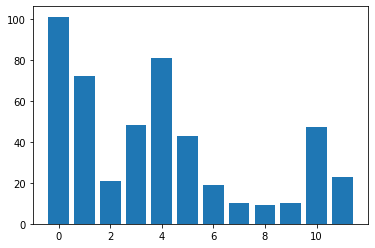

In [ ]:
from collections import Counter
from matplotlib import pyplot as plt

counter = Counter(y)
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
# View the percentages for each class
print("Class Representation in the original dataset:")
for target_class, value in counter.items():
	percentage = value / len(y) * 100
	print(' -Class=%s, n=%d (%.3f%%)' % (str(target_dict_rev[target_class]).zfill(5), value, percentage))

Class Representation in the original dataset:
 -Class=01110, n=101 (20.868%)
 -Class=11101, n=72 (14.876%)
 -Class=11001, n=21 (4.339%)
 -Class=11111, n=48 (9.917%)
 -Class=01100, n=81 (16.736%)
 -Class=01000, n=43 (8.884%)
 -Class=10001, n=19 (3.926%)
 -Class=00000, n=10 (2.066%)
 -Class=11011, n=9 (1.860%)
 -Class=00100, n=10 (2.066%)
 -Class=01010, n=47 (9.711%)
 -Class=10101, n=23 (4.752%)


####Applying SMOTE
We will now apply `SMOTE` to the data set. We will be using `SMOTE` that is provided in the `imblearn` python package. 

In [ ]:
%time
from imblearn.over_sampling import SMOTE

X = encoded_data.drop('target',axis="columns")
y = encoded_data['target']

smote = SMOTE()
X, y = smote.fit_resample(X,y)

y = y.apply(lambda x: target_dict[x])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.54 µs


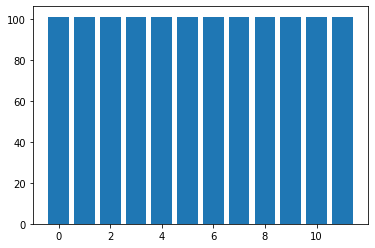

In [ ]:
counter = Counter(y)
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
# View the percentages for each class
print("Class Representation in the synthetic dataset:")
for target_class, value in counter.items():
	percentage = value / len(y) * 100
	print(' -Class=%s, n=%d (%.3f%%)' % (str(target_dict_rev[target_class]).zfill(5), value, percentage))

Class Representation in the synthetic dataset:
 -Class=01110, n=101 (8.333%)
 -Class=11101, n=101 (8.333%)
 -Class=11001, n=101 (8.333%)
 -Class=11111, n=101 (8.333%)
 -Class=01100, n=101 (8.333%)
 -Class=01000, n=101 (8.333%)
 -Class=10001, n=101 (8.333%)
 -Class=00000, n=101 (8.333%)
 -Class=11011, n=101 (8.333%)
 -Class=00100, n=101 (8.333%)
 -Class=01010, n=101 (8.333%)
 -Class=10101, n=101 (8.333%)


We now have a balanced dataset containing roughly the same proportion of each target value that we are interested in. `X` now holds all of our data that we are interested in, the real data and the newly created synthetic data. Similarly, `y` holds all the combinations of target values of the real data and the synthetica data.

In [ ]:
# Uncomment the line below to print out the X dataframe or y dataframe
#X
#y

##Training and Test
We can continue with our data and begin training. First we will train and test baseline models and then we will replicate the model that was built in the paper.

###Baseline Models
Here we will run some of the baseline models that the paper ran in the experiment. We will construct and train a Multilayer Perceptron (MLP), Support Vector Machines (SVM), Random Forest (RF) and Decision Tree (DT) using the `sklearn` deep learning library.

The paper stated that during this phase, a train and test split was done with 80-20 ratio. To keep things consistent, we will also use a train/test split of 80-20.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Split apart X and y from the synthetic data
X_set = X.drop(target_cols, axis='columns')
y_set = y

# Create 80-20 split like stated in the paper for all of the classifiers used
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.2)

# Print the shapes of each to see if they all match correctly
print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)
X_set

X_train.shape:  (969, 26)
X_test.shape:  (243, 26)
y_train.shape:  (969,)
y_test.shape:  (243,)


,age,sex_F,sex_M,faNoily_status_No,faNoily_status_Yes,religion_C,religion_M,religion_O,occupation_ARTISAN,occupation_C/SERVANT,...,status_M,status_S,loss_of_parent_No,loss_of_parent_Yes,divorse_No,divorse_Yes,Injury_No,Injury_Yes,Spiritual_consult_No,Spiritual_consult_Yes
0,18,0,1,0,1,1,0,0,0,0,...,0,1,0,1,1,0,1,0,0,1
1,22,0,1,0,1,1,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
2,35,0,1,1,0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0,1
3,30,0,1,0,1,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0,1
4,86,1,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,48,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
1208,31,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1209,34,0,0,0,1,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
1210,53,1,0,1,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,1


####1. Multilayer Perceptron (MLP)
To begin, we will start and define a Multilayer Perceptron Classifier (MLP) using the `sklearn` deep learning library.

In [ ]:
%time
# MLP Classifier
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(max_iter=500, activation='relu', random_state=42)
mlp_clf.fit(X_train,y_train)
y_pred = mlp_clf.predict(X_test)
print("MLP Accuracy:",accuracy_score(y_test,y_pred))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.58 µs
MLP Accuracy: 0.6460905349794238


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


####2. Support Vector Machine (SVM)
Next, we will start and define a Support Vector Machine Classifier (SVM) using the `sklearn` deep learning library.

In [ ]:
%time
# SVM Classifier
from sklearn.svm import SVC
svc_clf = SVC(kernel='linear', random_state=42)
svc_clf.fit(X_train,y_train)
y_pred = svc_clf.predict(X_test)
print("SVM Accuracy:",accuracy_score(y_test,y_pred))

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 7.87 µs
SVM Accuracy: 0.6213991769547325


####3. Random Forest (RF)
Next, we will start and define a Random Forest Classifier (MLP) using the `sklearn` deep learning library.

In [ ]:
%time
# RF Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
print("RF Accuracy:",accuracy_score(y_test,y_pred))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs
RF Accuracy: 0.7078189300411523


####4. Decision Tree (DT)
Next, we will start and define a Decision Tree Classifier (MLP) using the `sklearn` deep learning library.

In [ ]:
%time
# DT Classifier
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train,y_train)
y_pred = dt_clf.predict(X_test)
print("DT Accuracy:",accuracy_score(y_test,y_pred))

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.48 µs
DT Accuracy: 0.6172839506172839


In [ ]:
print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 11.9


###The Model Demonstrated in the Paper
